# Analyse de la qualité des eaux Chinoises


## Objectif 

À rédiger précisément dans le rapport.

Étudier et modéliser la qualité des eaux chinoises afin d'expliquer et de prédire un indice de pollution à partir des caractéristiques géographiques et de la composition chimique des eaux étudiées.

In [17]:
#imports
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import seaborn as sns
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error

In [18]:
#séparer le data set en testset 10% et trainset 90%
csv_path = 'dataset.csv'
df = pd.read_csv(csv_path)
df = df.drop(columns=['Unnamed: 0'], errors='ignore')  # errors='ignore' évite l'erreur si la colonne n'existe pas
RANDOM_STATE = 42
# séparation aléatoire 90%/10%
train_df, val_df = train_test_split(df, test_size=0.10, random_state=RANDOM_STATE)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(f'Total lignes: {len(df)} ; Train: {len(train_df)} ({len(train_df)/len(df):.2%}) ; Test: {len(val_df)} ({len(val_df)/len(df):.2%})')

Total lignes: 3000 ; Train: 2700 (90.00%) ; Test: 300 (10.00%)


## 3) Analyse descriptive des variables
Do a descriptive analysis of the variables of the model. Provide a table
 with mean, standard deviation, skewness and kurtosis. Show boxplots
 of the variables, and the correlation matrix.

---- Vérification des valeurs manquantes ----
Aucune valeur manquante détectée dans le jeu d'entraînement.
Doublons détectés : 0
---- Vérification des types et valeurs suspectes ----
Pas de colonnes 'object' avec valeurs numériques partielles détectées.
Dataset nettoyé

Table des statistiques descriptives (après nettoyage) :


,mean,sd,skewness,kurtosis
Water_Temperature_C,19.9880,4.9218,0.0224,-0.0312
pH,7.2079,0.5970,0.1994,-0.0897
Dissolved_Oxygen_mg_L,7.9947,1.9759,0.0133,-0.1442
Conductivity_uS_cm,509.5211,104.8794,0.0223,0.1503
Turbidity_NTU,5.0597,5.0686,2.0979,7.5884
Nitrate_mg_L,2.0279,0.5317,0.0970,0.0071
Nitrite_mg_L,0.0210,0.0097,0.1739,-0.2466
Ammonia_N_mg_L,0.5181,0.2059,0.1092,-0.2601
Total_Phosphorus_mg_L,0.1066,0.0487,0.1654,-0.3754
Total_Nitrogen_mg_L,3.0931,0.5249,0.1470,0.0633


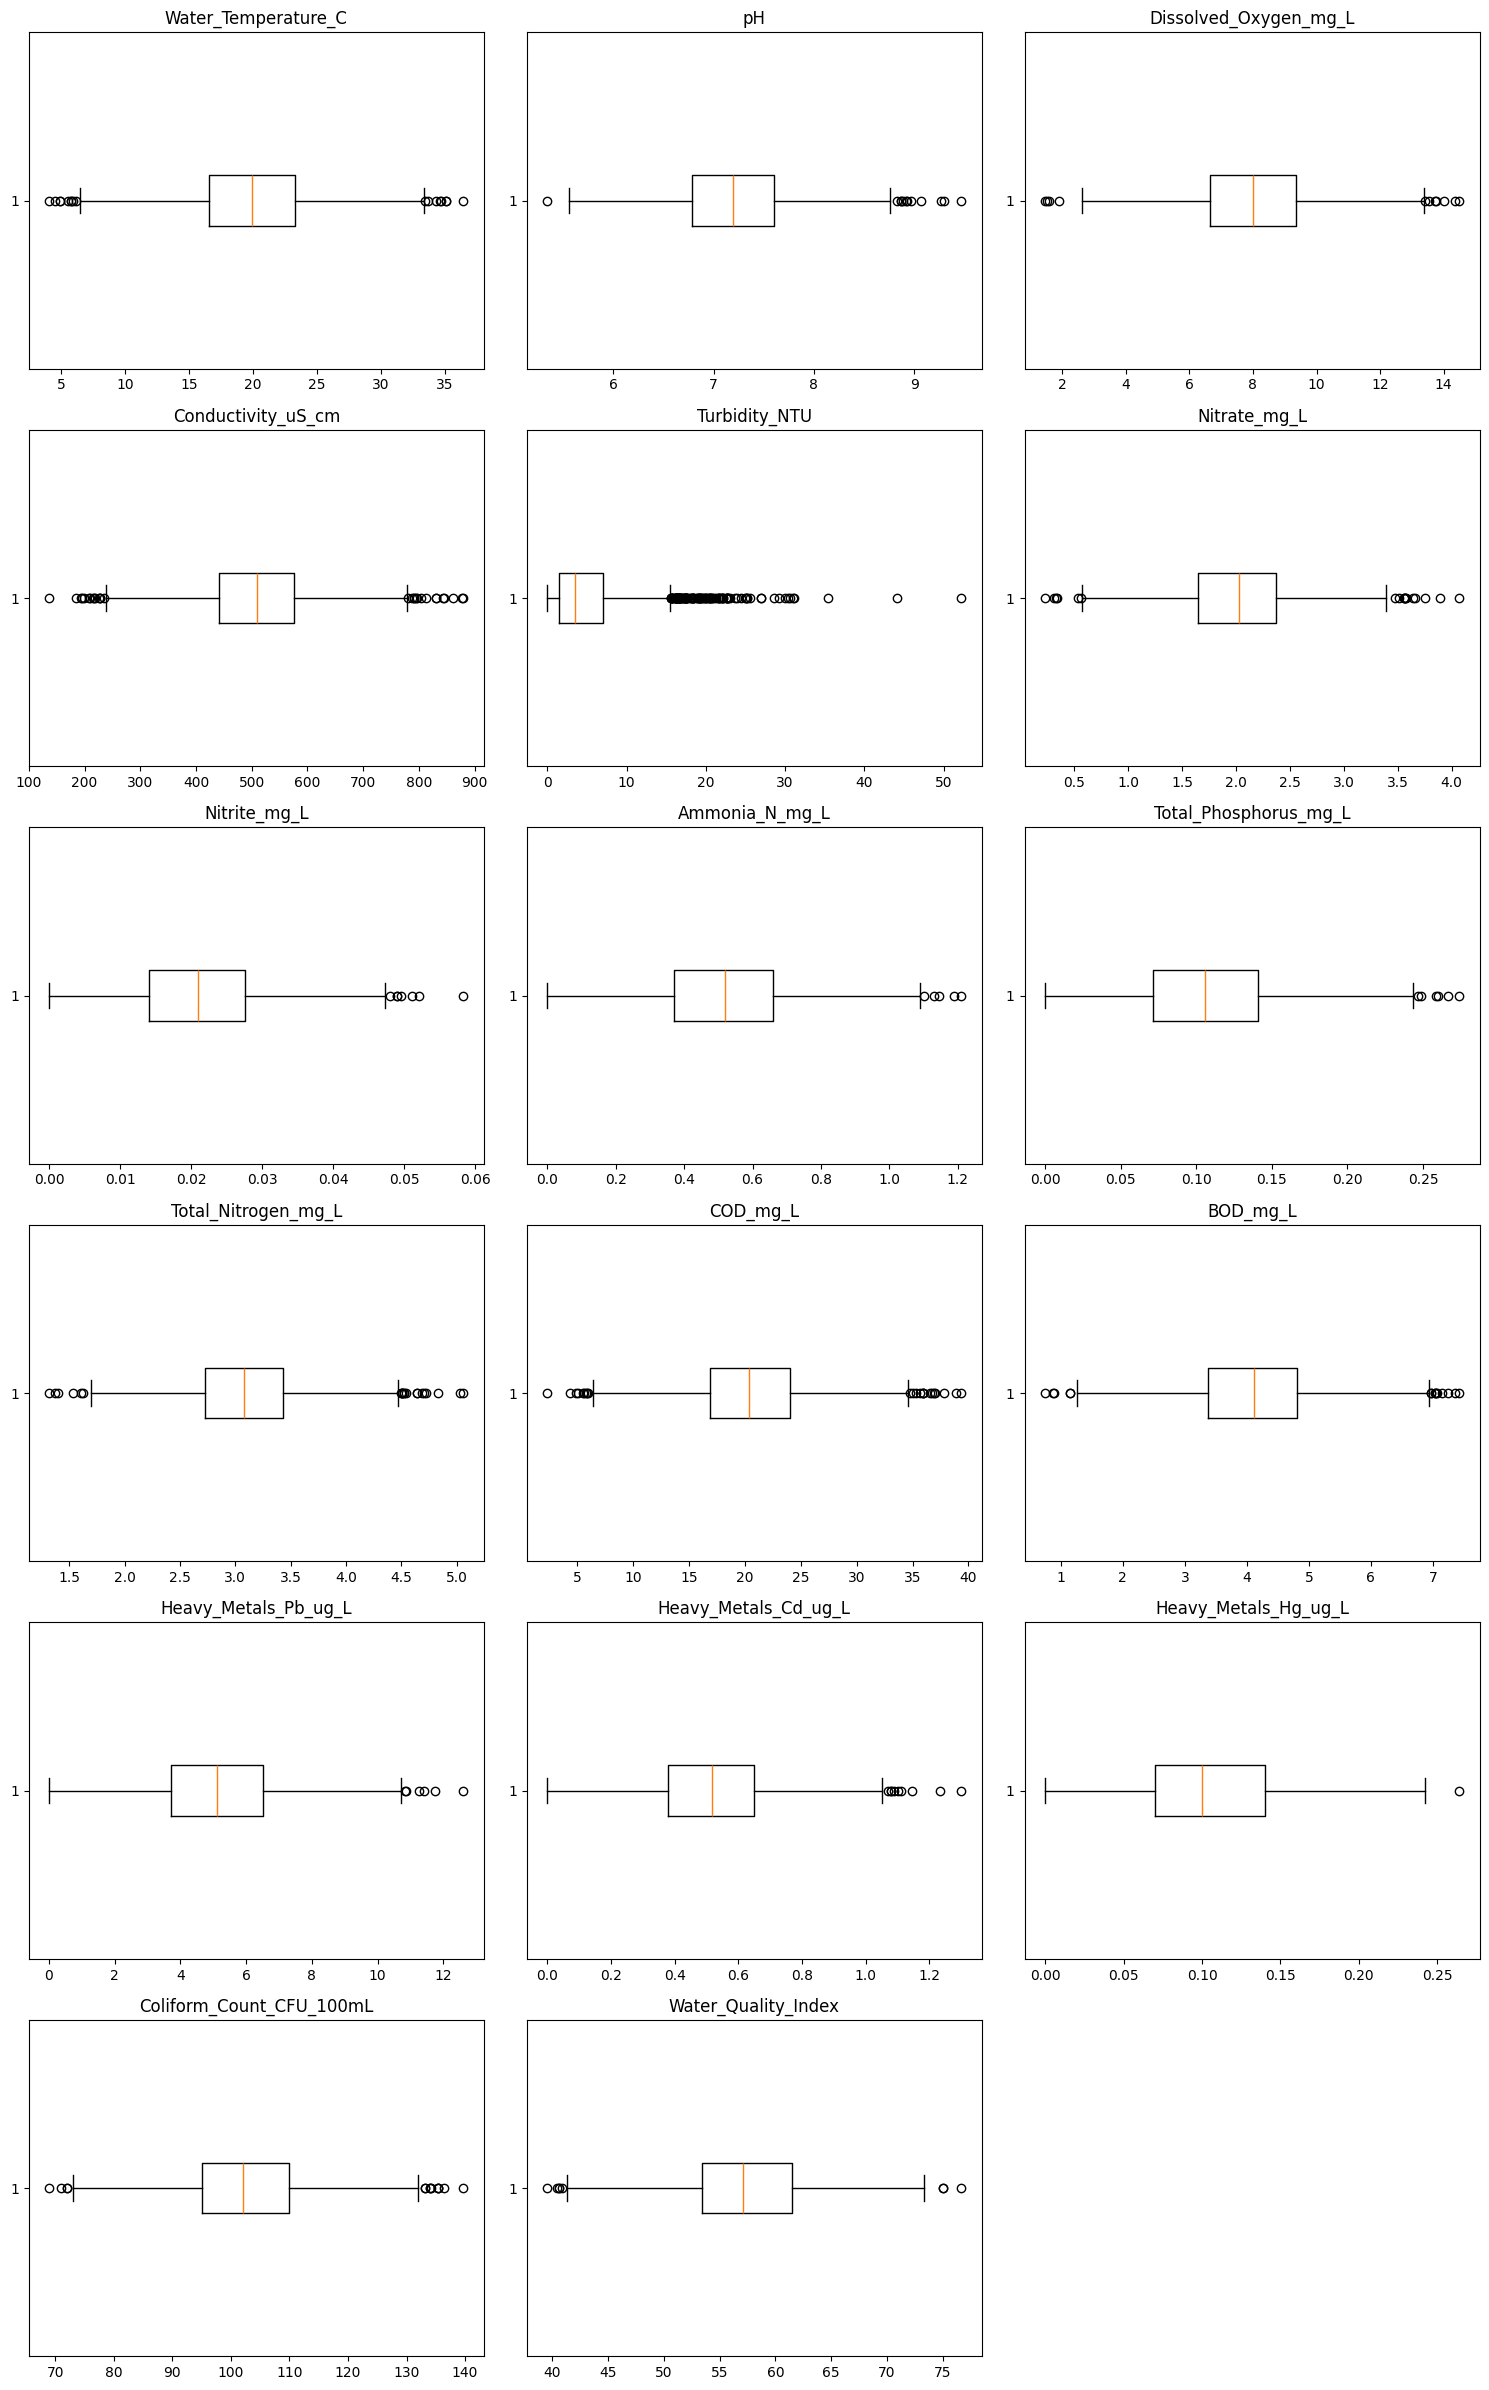

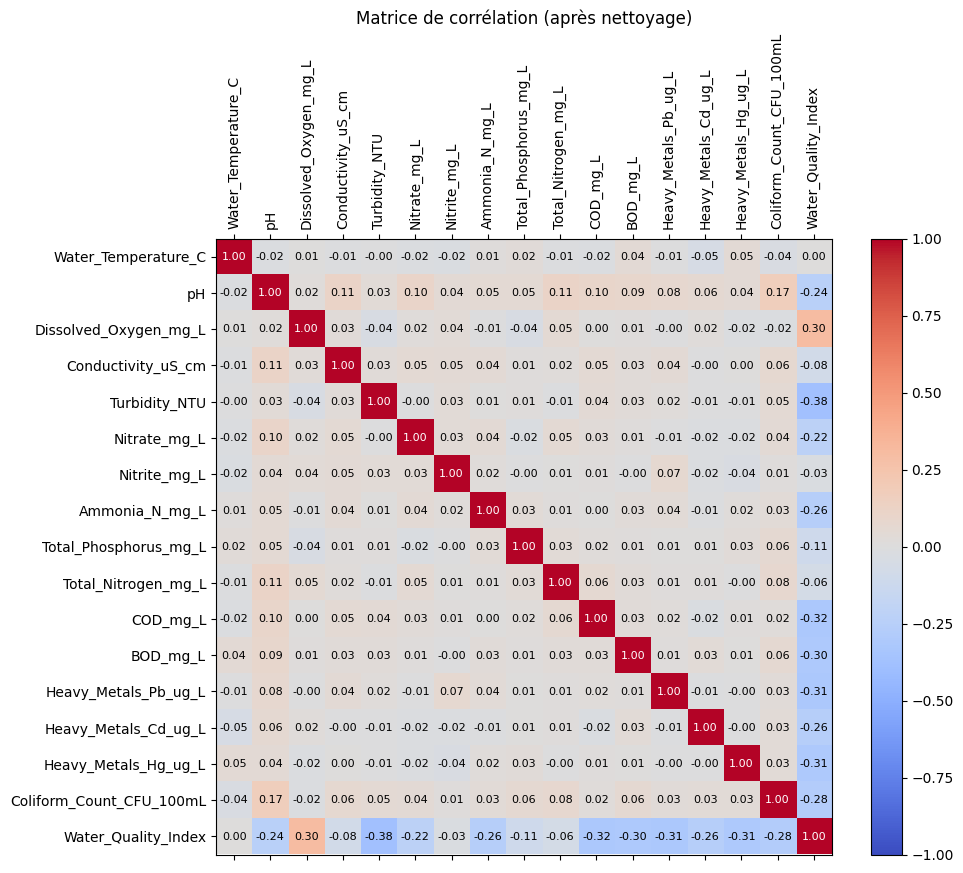

In [19]:
# Vérifications : valeurs manquantes + incohérences + calculs descriptifs
# Missing values
print("---- Vérification des valeurs manquantes ----")
missing_counts = train_df.isnull().sum()
missing_perc = (train_df.isnull().mean() * 100).round(2)
missing_df = pd.DataFrame({'missing_count': missing_counts, 'missing_%': missing_perc})
missing_df = missing_df[missing_df['missing_count'] > 0].sort_values('missing_%', ascending=False)
if missing_df.empty:
    print("Aucune valeur manquante détectée dans le jeu d'entraînement.")
else:
    display(missing_df)
    print("Exemples d'observations contenant au moins une valeur manquante :")
    display(train_df[train_df.isnull().any(axis=1)].head())

# Duplicates
dup = train_df.duplicated().sum()
print(f"Doublons détectés : {dup}")
if dup > 0:
    print("Exemples de lignes en double :")
    display(train_df[train_df.duplicated(keep=False)].head())

#Type / valeurs incohérentes (colonnes object contenant des valeurs numériques partiellement)
print("---- Vérification des types et valeurs suspectes ----")
obj_cols = train_df.select_dtypes(include=['object']).columns.tolist()
suspect_cols = {}
for col in obj_cols:
    coerced = pd.to_numeric(train_df[col], errors='coerce')
    n_numeric = coerced.notna().sum()
    if 0 < n_numeric < len(train_df):
        suspect_cols[col] = f"{n_numeric}/{len(train_df)} convertible en numérique"
if suspect_cols:
    print("Colonnes de type object contenant des valeurs numériques partiellement :")
    for k, v in suspect_cols.items():
        print(f" - {k}: {v}")
else:
    print("Pas de colonnes 'object' avec valeurs numériques partielles détectées.")

#Contrôles valeurs abérantes
ranges = {
    'pH': (0, 14),
    'Turbidity_NTU': (0, None),
    'Water_Temperature_C': (-20, 50),
    'Water_Quality_Index': (0, None)
}
for col, (low, high) in ranges.items():
    if col in train_df.columns:
        s = train_df[col]
        mask = pd.Series(False, index=s.index)
        if low is not None:
            mask = mask | (s < low)
        if high is not None:
            mask = mask | (s > high)
        nviol = int(mask.sum())
        if nviol > 0:
            print(f"{nviol} valeurs hors plage détectées pour {col} (attendu {low} à {high}). Exemples :")
            display(train_df.loc[mask, [col]].head())

# === Tout en un : détecter, afficher, nettoyer et analyser ===
concentration_cols = [c for c in train_df.columns if any(x in c for x in ['mg_L', 'ug_L', 'CFU', 'Count', 'Concentration'])]
# Forcer la conversion en numérique pour garantir une détection correcte
for c in concentration_cols:
    train_df[c] = pd.to_numeric(train_df[c], errors='coerce')

# Compter négatifs par colonne
neg_counts = {c: int((train_df[c] < 0).sum()) for c in concentration_cols}

# Lignes contenant au moins une valeur négative
mask_neg_row = pd.DataFrame({c: train_df[c] < 0 for c in concentration_cols}).any(axis=1) if concentration_cols else pd.Series(False, index=train_df.index)
rows_with_neg = int(mask_neg_row.sum())


# Nettoyage: suppression des lignes contenant des négatifs
n_before = len(train_df)
train_df = train_df.loc[~mask_neg_row].reset_index(drop=True)
print("Dataset nettoyé")
# Analyse descriptive sur le df nettoyé
num_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
stats_table = pd.DataFrame({
    'mean': train_df[num_cols].mean(),
    'sd': train_df[num_cols].std(),
    'skewness': train_df[num_cols].skew(),
    'kurtosis': train_df[num_cols].kurt()
}).round(4)

print('\nTable des statistiques descriptives (après nettoyage) :')
display(stats_table)

# Boxplots
cols = num_cols
n = len(cols)
ncols = 3
nrows = (n + ncols - 1) // ncols
plt.figure(figsize=(5 * ncols, 4 * max(1, nrows)))
for i, c in enumerate(cols, 1):
    plt.subplot(nrows, ncols, i)
    plt.boxplot(train_df[c].dropna(), vert=False)
    plt.title(c)
plt.tight_layout()
plt.show()

# Matrice de corrélation
corr = train_df[num_cols].corr()
fig, ax = plt.subplots(figsize=(10, 8))
cax = ax.matshow(corr, cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ax.set_xticks(range(len(num_cols)))
ax.set_yticks(range(len(num_cols)))
ax.set_xticklabels(num_cols, rotation=90)
ax.set_yticklabels(num_cols)
for (i, j), val in np.ndenumerate(corr.values):
    ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='white' if abs(val) > 0.5 else 'black', fontsize=8)
plt.title('Matrice de corrélation (après nettoyage)')
plt.show()

## 4) Sélection de modèle et vérification des hypothèses 
Select an adequate model for the response variable by considering all
 quantitative and qualitative variables and by using our model selec
tion strategies. Consider also possible interactions of the qualitative
 variables with one or several quantitative variables. Verify the under
lying hypotheses and, if necessary, take remedial actions. For example,
 check for : 
  (a) nonlinearity
 (b) outliers and/or influential observations,
 (c) multicollinearity,
 (d) heteroskedasticty, and
 (e) autocorrelation.

# +

 ## 5) Test for significance of the estimated coefficients 
Test for significance of the estimated coefficients of the obtained model,
and interpret their signs. Give a more detailed interpretation of the
coefficients of the qualitative variables.

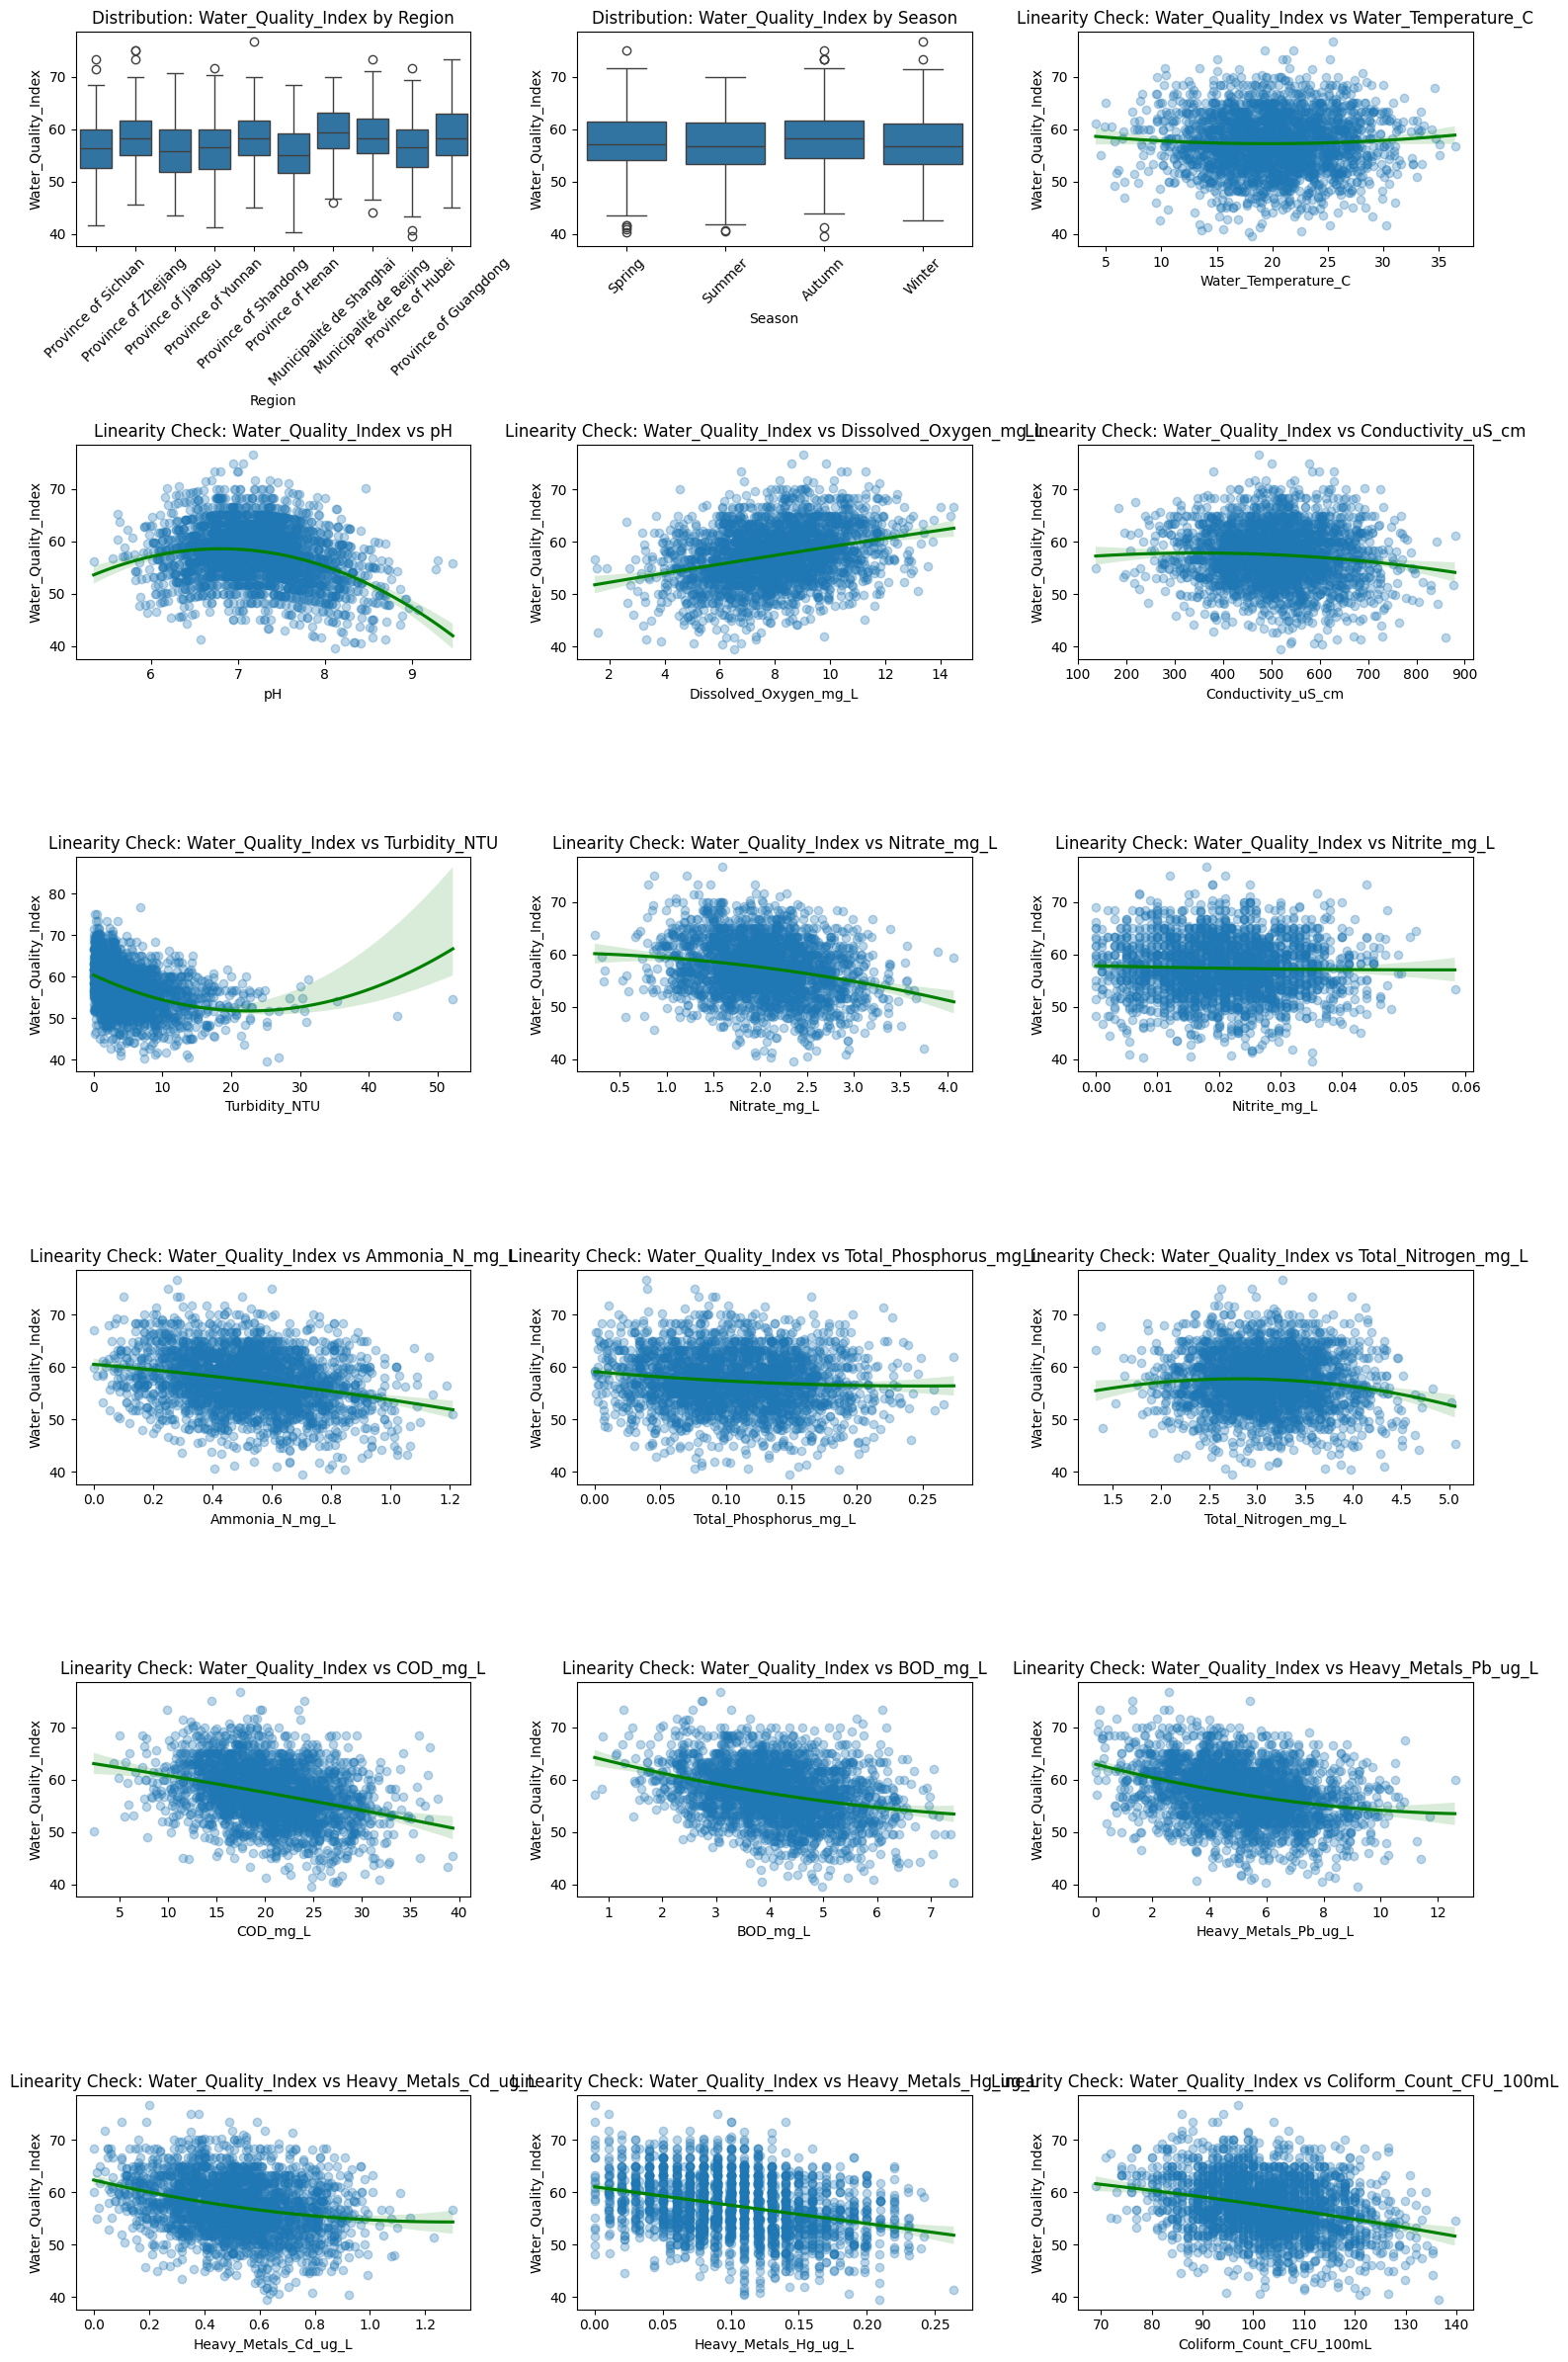

In [20]:

def pairwiseplot_for_linearity(df, y_var):
    #on récupère toutes les colonnes sauf la cible (y_var)
    x_vars = [col for col in df.columns if col != y_var and col != None]
    
    n = len(x_vars)
    ncols = 3  
    nrows = (n + ncols - 1) // ncols 
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows))
    axes = axes.flatten() if n > 1 else [axes]  
    
    for i, x_var in enumerate(x_vars):
        ax = axes[i]
        
        #x numérique
        if pd.api.types.is_numeric_dtype(df[x_var]):
            sns.regplot(data=df, x=x_var, y=y_var, 
                        order=2,  
                        scatter_kws={'alpha': 0.3}, 
                        line_kws={'color': 'green'},
                        ax=ax)
            ax.set_title(f"Linearity Check: {y_var} vs {x_var}")
            
        #x catégoriel
        else:
            sns.boxplot(data=df, x=x_var, y=y_var, ax=ax)
            ax.set_title(f"Distribution: {y_var} by {x_var}")
            ax.tick_params(axis='x', rotation=45)
        
        ax.set_xlabel(x_var)
        ax.set_ylabel(y_var)
    
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

pairwiseplot_for_linearity(train_df, "Water_Quality_Index")

In [21]:
#on utilise get_dummies pour transformer "Winter", "Spring" en 0 et 1.
train_df_encoded = pd.get_dummies(train_df, columns=['Region', 'Season'], drop_first=True, dtype=int)

X_train = train_df.copy()

X_train['pH_squared'] = X_train['pH'] ** 2
X_train['Turbidity_squared'] = X_train['Turbidity_NTU'] ** 2
X_train = pd.get_dummies(X_train, columns=['Region', 'Season'], drop_first=True, dtype=int)

y_train = X_train['Water_Quality_Index']
X_train = X_train.drop(columns=['Water_Quality_Index'])

X_train = sm.add_constant(X_train)

#estimation du modèle complet
model_full = sm.OLS(y_train, X_train).fit()

print(model_full.summary())

                             OLS Regression Results                            
Dep. Variable:     Water_Quality_Index   R-squared:                       0.865
Model:                             OLS   Adj. R-squared:                  0.863
Method:                  Least Squares   F-statistic:                     526.3
Date:                 Wed, 31 Dec 2025   Prob (F-statistic):               0.00
Time:                         13:20:54   Log-Likelihood:                -5287.2
No. Observations:                 2494   AIC:                         1.064e+04
Df Residuals:                     2463   BIC:                         1.082e+04
Df Model:                           30                                         
Covariance Type:             nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------


In [22]:
#VIF -> check de la multicolinéarité + centrer pH et Turbidity
mean_pH = train_df['pH'].mean()
mean_Turb = train_df['Turbidity_NTU'].mean()

X_train['pH_centered'] = train_df['pH'] - mean_pH
X_train['pH_sq_centered'] = X_train['pH_centered'] ** 2

X_train['Turb_centered'] = train_df['Turbidity_NTU'] - mean_Turb
X_train['Turb_sq_centered'] = X_train['Turb_centered'] ** 2

#on évite les doublons pour pas casser le model
vars_to_drop = ['pH', 'pH_squared', 'Turbidity_NTU', 'Turbidity_squared', 'const']

#redondance
vars_to_drop += ['Total_Nitrogen_mg_L', 'Total_Phosphorus_mg_L'] 
X_clean = X_train.drop(columns=vars_to_drop, errors='ignore')

vif_data = pd.DataFrame()
vif_data["Variable"] = X_clean.columns
vif_data["VIF"] = [variance_inflation_factor(X_clean.values, i) for i in range(len(X_clean.columns))]
vif_data = vif_data.sort_values('VIF', ascending=False)

print(vif_data)

                           Variable        VIF
11         Coliform_Count_CFU_100mL  58.066567
2                Conductivity_uS_cm  23.500963
0               Water_Temperature_C  16.341226
1             Dissolved_Oxygen_mg_L  16.321250
7                          BOD_mg_L  16.089433
6                          COD_mg_L  15.357393
3                      Nitrate_mg_L  15.061670
9              Heavy_Metals_Cd_ug_L   7.684709
8              Heavy_Metals_Pb_ug_L   7.506404
5                    Ammonia_N_mg_L   7.347984
4                      Nitrite_mg_L   5.740397
10             Heavy_Metals_Hg_ug_L   5.512379
18       Region_Province of Sichuan   2.143370
22                    Season_Summer   2.105438
27                 Turb_sq_centered   2.069421
21                    Season_Spring   2.051599
15         Region_Province of Hubei   2.043720
14         Region_Province of Henan   2.034305
23                    Season_Winter   2.032079
19        Region_Province of Yunnan   2.016373
16       Regi

In [23]:
#on enlève les VIF > 10 (surtout les très hauts) combinés d'une p-val > 0.05 ou alors trop proches d'autres variables
vars_to_drop = ['Water_Temperature_C', 'Conductivity_uS_cm', 
              'Coliform_Count_CFU_100mL']

X_final_vif = X_clean.drop(columns=vars_to_drop, errors='ignore')

vif_data = pd.DataFrame()
vif_data["Variable"] = X_final_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_final_vif .values, i) for i in range(len(X_final_vif.columns))]
vif_data = vif_data.sort_values('VIF', ascending=False)

print(vif_data)

                           Variable        VIF
0             Dissolved_Oxygen_mg_L  14.808394
5                          BOD_mg_L  14.532787
4                          COD_mg_L  14.070926
1                      Nitrate_mg_L  13.762127
7              Heavy_Metals_Cd_ug_L   7.376728
6              Heavy_Metals_Pb_ug_L   7.247480
3                    Ammonia_N_mg_L   7.090229
2                      Nitrite_mg_L   5.623864
8              Heavy_Metals_Hg_ug_L   5.308054
19                    Season_Summer   2.077115
24                 Turb_sq_centered   2.068922
15       Region_Province of Sichuan   2.065914
18                    Season_Spring   2.027627
20                    Season_Winter   1.998328
12         Region_Province of Hubei   1.968342
11         Region_Province of Henan   1.959651
16        Region_Province of Yunnan   1.930144
13       Region_Province of Jiangsu   1.908342
17      Region_Province of Zhejiang   1.904130
10     Region_Province of Guangdong   1.888379
23           

In [24]:
X_curr = sm.add_constant(X_final_vif) 
model_step1 = sm.OLS(y_train, X_curr).fit()

print(model_step1.summary())

                             OLS Regression Results                            
Dep. Variable:     Water_Quality_Index   R-squared:                       0.837
Model:                             OLS   Adj. R-squared:                  0.836
Method:                  Least Squares   F-statistic:                     508.5
Date:                 Wed, 31 Dec 2025   Prob (F-statistic):               0.00
Time:                         13:20:54   Log-Likelihood:                -5519.5
No. Observations:                 2494   AIC:                         1.109e+04
Df Residuals:                     2468   BIC:                         1.124e+04
Df Model:                           25                                         
Covariance Type:             nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------


In [25]:
#on nettoie selon la p-val, mtn que le model est beaucoup plus significatif
vars_to_drop_final = [
    'Nitrite_mg_L',                     # P = 0.525
    'Region_Municipalité de Shanghai',  # P = 0.821
    'Region_Province of Shandong',      # P = 0.819  
    'Region_Province of Zhejiang',      # P = 0.379   
    'Season_Spring',                    # P = 0.126     
    'Season_Summer',
    'Season_Winter'
]
X_final_clean = X_curr.drop(columns=vars_to_drop_final, errors='ignore')

X_final_clean = sm.add_constant(X_final_clean)
model_final_clean = sm.OLS(y_train, X_final_clean).fit()

print(model_final_clean.summary())

                             OLS Regression Results                            
Dep. Variable:     Water_Quality_Index   R-squared:                       0.837
Model:                             OLS   Adj. R-squared:                  0.836
Method:                  Least Squares   F-statistic:                     705.6
Date:                 Wed, 31 Dec 2025   Prob (F-statistic):               0.00
Time:                         13:20:54   Log-Likelihood:                -5523.5
No. Observations:                 2494   AIC:                         1.108e+04
Df Residuals:                     2475   BIC:                         1.120e+04
Df Model:                           18                                         
Covariance Type:             nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const 

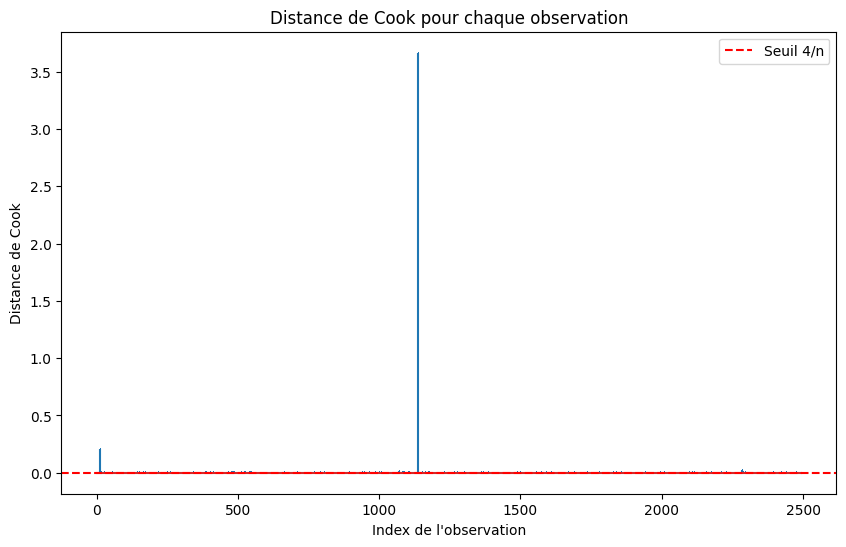

In [26]:
#cook distances
influence = model_final_clean.get_influence()
cooks_d = influence.cooks_distance[0]
n = len(X_final_clean)

plt.figure(figsize=(10, 6))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.axhline(y=4/n, color='r', linestyle='--', label='Seuil 4/n')
plt.title("Distance de Cook pour chaque observation")
plt.xlabel("Index de l'observation")
plt.ylabel("Distance de Cook")
plt.legend()
plt.show()

In [27]:
idx_coupable = np.argmax(cooks_d)
print(f"L'observation problématique est à l'index : {idx_coupable}")

indices_a_supprimer = [1237, 15]
#suppression des points hyper-influents
X_final_sans_outlier = X_final_clean.drop(index=indices_a_supprimer, errors='ignore')
y_train_sans_outlier = y_train.drop(index=indices_a_supprimer, errors='ignore')
model_final_final = sm.OLS(y_train_sans_outlier, X_final_sans_outlier).fit()

print(f"R-squared avant : {model_final_clean.rsquared:.4f}")
print(f"R-squared après : {model_final_final.rsquared:.4f}")
print(model_final_final.summary())

L'observation problématique est à l'index : 1137
R-squared avant : 0.8369
R-squared après : 0.8370
                             OLS Regression Results                            
Dep. Variable:     Water_Quality_Index   R-squared:                       0.837
Model:                             OLS   Adj. R-squared:                  0.836
Method:                  Least Squares   F-statistic:                     705.4
Date:                 Wed, 31 Dec 2025   Prob (F-statistic):               0.00
Time:                         13:20:55   Log-Likelihood:                -5519.3
No. Observations:                 2492   AIC:                         1.108e+04
Df Residuals:                     2473   BIC:                         1.119e+04
Df Model:                           18                                         
Covariance Type:             nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
----

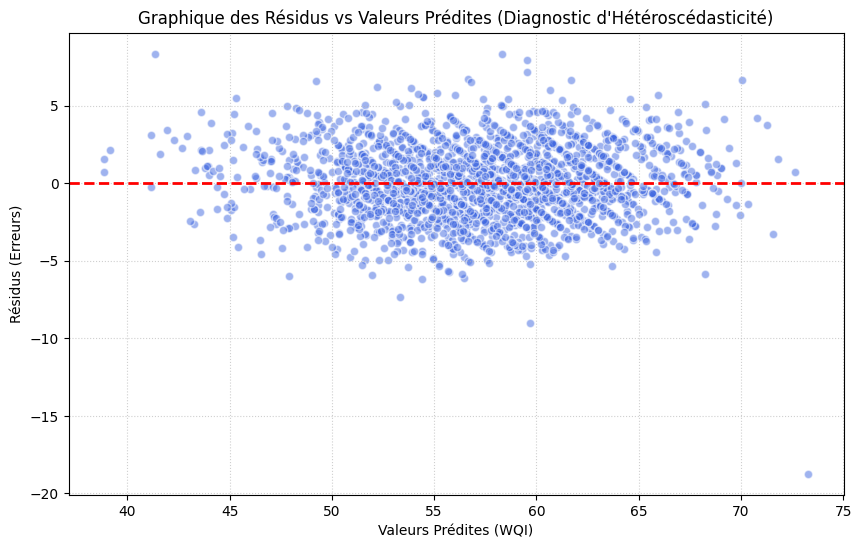

In [28]:
import matplotlib.pyplot as plt

#calcul des résidus et des valeurs prédites
residuals = model_final_final.resid
fitted_values = model_final_final.fittedvalues

plt.figure(figsize=(10, 6))
plt.scatter(fitted_values, residuals, alpha=0.5, color='royalblue', edgecolors='white')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title("Graphique des Résidus vs Valeurs Prédites (Diagnostic d'Hétéroscédasticité)")
plt.xlabel("Valeurs Prédites (WQI)")
plt.ylabel("Résidus (Erreurs)")
plt.grid(True, linestyle=':', alpha=0.6)
plt.show()

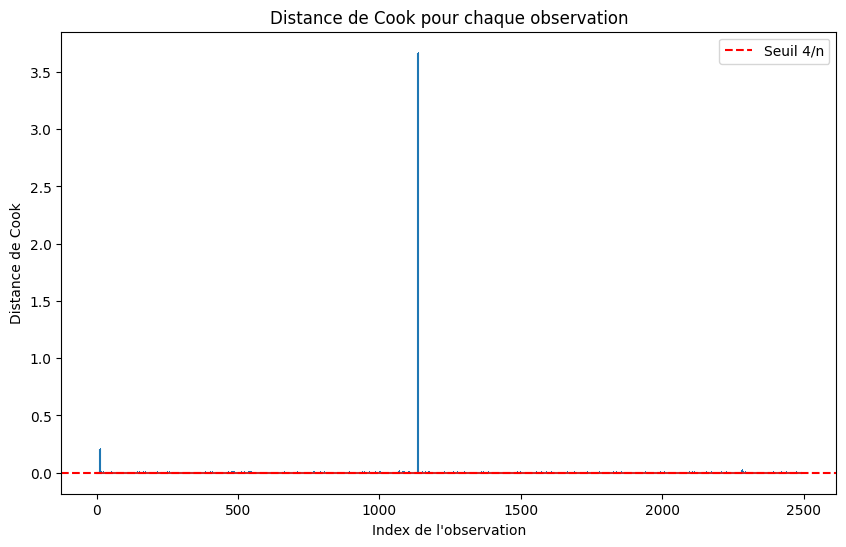

In [29]:
influence = model_final_final.get_influence()
cooks_d = influence.cooks_distance[0]
n = len(X_final_sans_outlier)

plt.figure(figsize=(10, 6))
plt.stem(np.arange(len(cooks_d)), cooks_d, markerfmt=",")
plt.axhline(y=4/n, color='r', linestyle='--', label='Seuil 4/n')
plt.title("Distance de Cook pour chaque observation")
plt.xlabel("Index de l'observation")
plt.ylabel("Distance de Cook")
plt.legend()
plt.show()

In [30]:
X_val_final = X_final_sans_outlier.drop(columns=vars_to_drop_final, errors='ignore')
X_val_final = sm.add_constant(X_val_final)

y_pred_final = model_final_final.predict(X_val_final)

#mspe
mspe_final = mean_squared_error(y_train_sans_outlier, y_pred_final)

print(f"MSPE du modèle final (nettoyé) : {mspe_final:.4f}")

MSPE du modèle final (nettoyé) : 4.9124


## 6) Test d'une combinaison linéaire à 2 coefficients


In [31]:
#H0 : L'impact du Plomb est égal à celui du Cadmium
test_q6 = model_final_final.t_test("Heavy_Metals_Pb_ug_L = Heavy_Metals_Cd_ug_L")
print(test_q6)

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             6.6658      0.227     29.358      0.000       6.221       7.111


## 7) Test d'un sous-ensemble de coefficients égaux à zéro


In [37]:
# Test conjoint des coefficients liés à la saison
# H0 : βSpring = βSummer = βWinter = 0 (Automne = catégorie de référence)
# H1 : au moins un coefficient saisonnier est non nul

vars_season = [v for v in model_final_final.params.index if "Season" in v]

if vars_season:
    hypothesis = " = 0, ".join(vars_season) + " = 0"
    f_test = model_final_final.f_test(hypothesis)

    print(f"Statistique F : {f_test.fvalue:.4f}")
    print(f"P-value : {f_test.pvalue:.4f}")

    if f_test.pvalue < 0.05:
        print("Conclusion : On rejette H0. Au moins un coefficient saisonnier est non nul (référence : Autumn).")
    else:
        print("Conclusion : On ne rejette pas H0. Les saisons n'ont pas d'effet significatif une fois les autres variables contrôlées (référence : Autumn).")

else:
    season_cols = [c for c in X_train.columns if "Season" in c] if 'X_train' in globals() else []

    if not season_cols:
        print("Ajout impossible des variables Season.")
    else:
        print("Ajout des dummies Season (référence : Autumn).")

        X_aug = X_final_sans_outlier.copy()
        for col in season_cols:
            if col in X_train.columns:
                X_aug[col] = X_train.loc[y_train_sans_outlier.index, col]
            else:
                X_aug[col] = 0

        X_aug = sm.add_constant(X_aug, has_constant='skip')
        model_aug = sm.OLS(y_train_sans_outlier, X_aug).fit()

        hypotheses = [f"{c} = 0" for c in season_cols if c in model_aug.params.index]

        if not hypotheses:
            print("Erreur : les dummies Season n'ont pas été correctement ajoutées.")
        else:
            hypothesis = ", ".join(hypotheses)
            f_test = model_aug.f_test(hypothesis)

            print(f"Statistique F (modèle augmenté) : {f_test.fvalue:.4f}")
            print(f"P-value : {f_test.pvalue:.4f}")

            if f_test.pvalue < 0.05:
                print("Conclusion : On rejette H0. Au moins un coefficient saisonnier est non nul (référence : Autumn).")
            else:
                print("Conclusion : On ne rejette pas H0. Les saisons n'ont pas d'effet significatif (référence : Autumn).")


Ajout des dummies Season (référence : Autumn).
Statistique F (modèle augmenté) : 2.4680
P-value : 0.0603
Conclusion : On ne rejette pas H0. Les saisons n'ont pas d'effet significatif (référence : Autumn).


## 8) Intervalles de prédiction pour les données de validation
Calculate prediction intervals for the validation data. Does the cover
age percentage of these intervals correspond to the nominal level? If
 not, what could be a reason?

In [33]:
# 1. Feature Engineering sur le set de VALIDATION (identique au train)
X_val = val_df.copy()

# Création des termes carrés et dummies
X_val['pH_squared'] = X_val['pH'] ** 2
X_val['Turbidity_squared'] = X_val['Turbidity_NTU'] ** 2
X_val = pd.get_dummies(X_val, columns=['Region', 'Season'], drop_first=True, dtype=int)

# 2. Centrage (IMPORTANT : utiliser mean_pH et mean_Turb calculés sur le TRAIN en cellule 9)
X_val['pH_centered'] = X_val['pH'] - mean_pH
X_val['pH_sq_centered'] = X_val['pH_centered'] ** 2
X_val['Turb_centered'] = X_val['Turbidity_NTU'] - mean_Turb
X_val['Turb_sq_centered'] = X_val['Turb_centered'] ** 2

# 3. Alignement des colonnes
# On ne garde que les colonnes présentes dans le modèle final (hors constante qu'on ajoute après)
cols_model = model_final_final.params.index.drop('const')

# Si une colonne du modèle manque dans la validation (ex: une région absente du test set), on l'ajoute remplie de 0
for col in cols_model:
    if col not in X_val.columns:
        X_val[col] = 0

X_val = X_val[cols_model] # On ordonne comme le train
X_val = sm.add_constant(X_val) # On ajoute la constante

# 4. Prédictions et Intervalles
predictions = model_final_final.get_prediction(X_val)
pred_frame = predictions.summary_frame(alpha=0.05) # alpha 0.05 pour 95% confiance

# 5. Calcul de la couverture
y_true = val_df['Water_Quality_Index']
is_covered = (y_true >= pred_frame['obs_ci_lower']) & (y_true <= pred_frame['obs_ci_upper'])
coverage = is_covered.mean() * 100

print(f"Couverture des intervalles de prédiction (95% nominal) : {coverage:.2f}%")

# RMSE pour info
rmse_val = np.sqrt(mean_squared_error(y_true, pred_frame['mean']))
print(f"RMSE sur Validation : {rmse_val:.4f}")

Couverture des intervalles de prédiction (95% nominal) : 94.33%
RMSE sur Validation : 2.2153


### Conclusion du point 8

## 9) Conclusion


## 10) Déclaration d'utilisation d'IA


tkt